<img src="images/hypernet.svg" width=50% align="right">
# HyperNeworks
Author: Jin Yeom (jinyeom@utexas.edu)  
Original authors: David Ha, Andrew Dai, Quoc V. Le

## Contents
- [Configuration](#Configuration)
- [Utility functions](#Utility-functions)
- [Static HyperNet](#Static-HyperNet)
- [Dynamic HyperNet](#Dynamic-HyperNet)
- [References](#References)

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision import datasets
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib inline

## Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


## Utility functions

In [4]:
def imshow(img, title, figsize=(16, 8)):
    npimg = img.detach().numpy()
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [5]:
def num_params(model, requires_grad=False):
    if requires_grad:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

## Static HyperNet

In [6]:
class HyperNet(nn.Module):
    def __init__(self, z_dim, in_channels, out_channels, kernel_size):
        super(HyperNet, self).__init__()
        self.fc1 = nn.Linear(z_dim, in_channels * z_dim)        
        self.fc2 = nn.Linear(z_dim, out_channels * kernel_size * kernel_size)
        
    def forward(self, z):
        z = self.fc1(z)
        z = z.view(in_channels, z_dim)
        z = self.fc2(z)
        z = z.view(out_channels, in_channels, kernel_size, kernel_size)
        return z

number of trainable parameters: 4240
number of generated weights: 12544


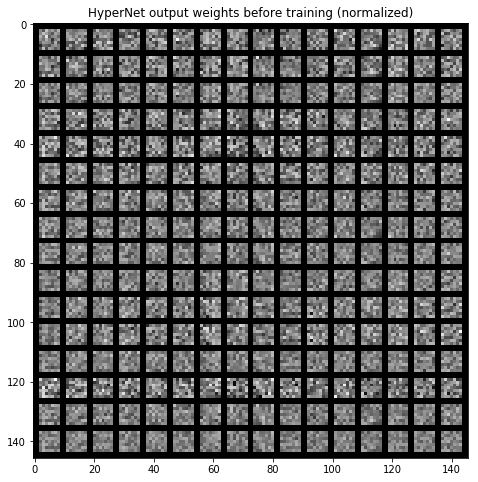

In [7]:
z_dim = 4
in_channels = 16
out_channels = 16
kernel_size = 7

z = torch.randn(z_dim, requires_grad=True)
hn = HyperNet(z_dim, in_channels, out_channels, kernel_size)
W = hn(z)

n_params = num_params(hn, requires_grad=True)
n_weights = in_channels * out_channels * kernel_size * kernel_size
print(f"number of trainable parameters: {n_params}")
print(f"number of generated weights: {n_weights}")

W_vis = W.view(in_channels * out_channels, 1, kernel_size, kernel_size)
imshow(make_grid(W_vis, nrow=in_channels, normalize=True), 
       "HyperNet output weights before training (normalized)")

In [8]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=1, out_features=10, use_hn=False):
        super(ConvNet, self).__init__()
        self._use_hn = use_hn
        self.conv1 = nn.Conv2d(in_channels, 16, 7, stride=1, padding=2)
        if self._use_hn:
            self.hn = HyperNet(4, 16, 16, 7)     
            self.z = torch.randn(4, requires_grad=True)
            self.conv2_W = self.hn(self.z)
            self.conv2_b = torch.zeros(16, requires_grad=True)
        else:
            self.conv2 = nn.Conv2d(16, 16, 7, stride=2)
        self.fc3 = nn.Linear(784, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2), stride=(2, 2), padding=1)
        if self._use_hn:
            x = F.conv2d(x, self.conv2_W, self.conv2_b, padding=2)
        else:
            self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2), stride=(2, 2), padding=1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.fc3(x), dim=1)

In [9]:
model1 = ConvNet()
model2 = ConvNet(use_hn=True)

print("Trainable paramters without HN: {}".format(num_params(model1, requires_grad=True)))
print("Trainable paramters with HN: {}".format(num_params(model2, requires_grad=True)))

Trainable paramters without HN: 21210
Trainable paramters with HN: 12890


In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_train = datasets.MNIST("datasets/mnist",
                             train=True,
                             transform=transform,
                             download=True)
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=2)

mnist_test = datasets.MNIST("datasets/mnist",
                            train=False,
                            transform=transform,
                            download=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=64,
                                          shuffle=False,
                                          num_workers=2)

In [11]:
print("datasets/mnist/raw:")
!ls datasets/mnist/raw
print("datasets/mnist/processed:")
!ls datasets/mnist/processed

datasets/mnist/raw:
t10k-images-idx3-ubyte  train-images-idx3-ubyte
t10k-labels-idx1-ubyte  train-labels-idx1-ubyte
datasets/mnist/processed:
test.pt     training.pt


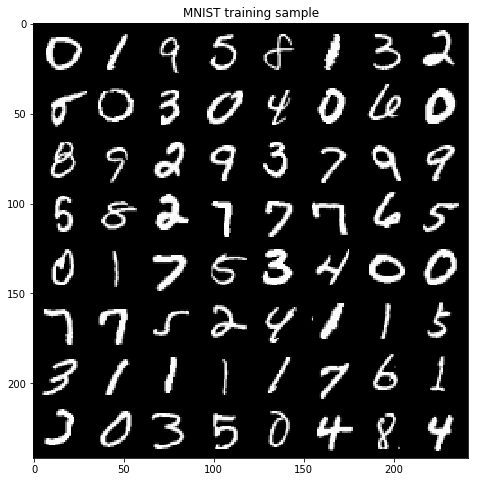

  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiprocessin

In [12]:
train_iter = iter(train_loader)
images, labels = train_iter.next()
imshow(make_grid(images, nrow=8, normalize=True), "MNIST training sample")

In [13]:
def validate(model, test_loader):
    model.eval()
    accuracy = 0.0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            pred = model(data).max(1, keepdim=True)[1] # index of max log-prob
            accuracy += pred.eq(label.view_as(pred)).sum().item()
    return 100.0 * accuracy / len(test_loader.dataset)

In [14]:
def update_figure(fig, ax, data, title, xlabel, ylabel):
    ax.clear()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(data)
    plt.show()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


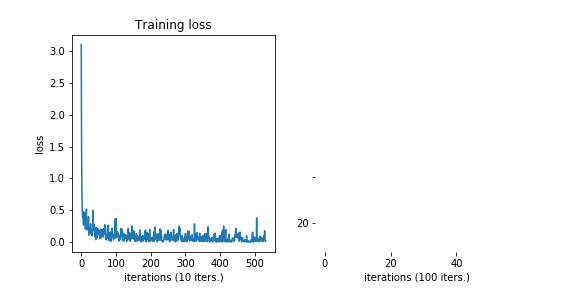

HBox(children=(IntProgress(value=0, description='epochs', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='iters.', max=938), HTML(value='')))

HBox(children=(IntProgress(value=0, description='iters.', max=938), HTML(value='')))

HBox(children=(IntProgress(value=0, description='iters.', max=938), HTML(value='')))

HBox(children=(IntProgress(value=0, description='iters.', max=938), HTML(value='')))

HBox(children=(IntProgress(value=0, description='iters.', max=938), HTML(value='')))

HBox(children=(IntProgress(value=0, description='iters.', max=938), HTML(value='')))

Process Process-113:
Process Process-114:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/jinseok.yeom/anaconda3/lib/python3.6/multiproce

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


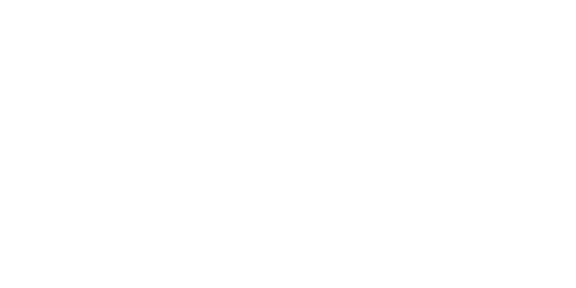

In [15]:
%matplotlib notebook

fig, (ax_train, ax_validate) = plt.subplots(1, 2, figsize=(8, 4))

train_losses = [] # training losses every 10 iterations
validate_acc = [] # validation accuracy every 100 iterations

model = ConvNet(use_hn=True).to(device)
optimizer = optim.Adam(model.parameters())
for epoch in tqdm(range(10), desc="epochs"):
    model.train()
    for i, (data, label) in enumerate(tqdm(train_loader, desc="iters.", leave=False)):
        optimizer.zero_grad()
        
        data = data.to(device)
        label = label.to(device)
        pred = model(data)
        
        loss = F.nll_loss(pred, label)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if i % 10 == 0:
            train_losses.append(loss.item())
            update_figure(fig,
                          ax_train,
                          train_losses,
                          "Training loss",
                          "iterations (10 iters.)",
                          "loss")
            
        if i % 100 == 0:
            # every 100 iterations, record the model's validation
            accuracy = validate(model, test_loader)
            validate_acc.append(accuracy)
            update_figure(fig,
                          ax_validate,
                          validate_acc,
                          "Validation accuracy",
                          "iterations (100 iters.)",
                          "accuracy (%)")
            
conv2_W_vis = make_grid(model.conv2_W.view(256, 1, 7, 7), nrow=16, normalize=True)
imshow(conv2_W_vis, "Hypernet-generated weights after training (normalized)", figsize=(12, 12))

## Dynamic HyperNet

## References

- HyperNetworks, [arXiv:1609.09106v4](https://arxiv.org/abs/1609.09106v4) \[cs.LG\]